In [ ]:
!pip install numpy
!pip install opencv-python
!pip install matplotlib
!pip install Pillow

In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image, ExifTags

%matplotlib inline

PATH = './'
assert os.path.exists(PATH)

def imreadExpand(filepath):
    # 방향 교정을 위해 PIL을 사용하여 이미지 로드
    img_pil = Image.open(filepath)
    
    # EXIF 방향 태그가 있는 경우 이미지 방향 교정
    try:
        for orientation in ExifTags.TAGS.keys():
            if ExifTags.TAGS[orientation] == 'Orientation':
                break
        
        exif = img_pil._getexif()
        if exif is not None:
            orientation_value = exif.get(orientation)

            if orientation_value == 3:
                img_pil = img_pil.rotate(180, expand=True)
            elif orientation_value == 6:
                img_pil = img_pil.rotate(270, expand=True)
            elif orientation_value == 8:
                img_pil = img_pil.rotate(90, expand=True)
    except (AttributeError, KeyError, IndexError):
        # 문제가 발생할 경우 회전 없이 그대로 진행
        pass

    # PIL 이미지를 OpenCV 형식으로 변환
    img_cv = np.array(img_pil)
    if img_cv.shape[-1] == 3:
        img_cv = cv2.cvtColor(img_cv, cv2.COLOR_RGB2BGR)
    
    return img_cv

img1 = imreadExpand(PATH + '/img_2.jpg')
img2 = imreadExpand(PATH + '/img_1.jpg')
img3 = imreadExpand(PATH + '/img_3.jpg')
img4 = imreadExpand(PATH + '/img_4.jpg')
img5 = imreadExpand(PATH + '/img_5.jpg')

assert img1 is not None

# 이미지 크기 256x256으로 고정
img_size = (256, 256)
img1 = cv2.resize(img1, img_size, interpolation=cv2.INTER_AREA)
img2 = cv2.resize(img2, img_size, interpolation=cv2.INTER_AREA)
img3 = cv2.resize(img3, img_size, interpolation=cv2.INTER_AREA)
img4 = cv2.resize(img4, img_size, interpolation=cv2.INTER_AREA)
img5 = cv2.resize(img5, img_size, interpolation=cv2.INTER_AREA)


### Horizontal

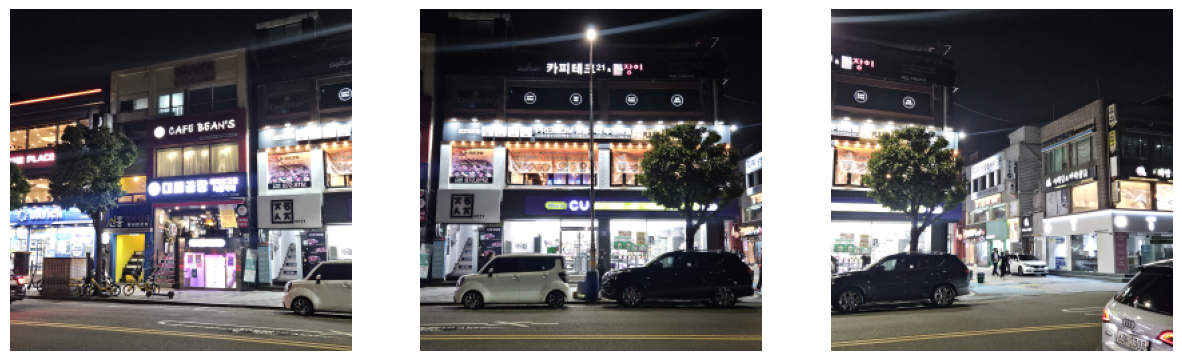

In [ ]:
fig = plt.figure()
rows, cols = 1, 3

ax1 = fig.add_subplot(rows, cols, 1)
ax1.imshow(cv2.cvtColor(img1, cv2.COLOR_RGB2BGR))
ax1.axis('off')

ax2 = fig.add_subplot(rows, cols, 2)
ax2.imshow(cv2.cvtColor(img2, cv2.COLOR_RGB2BGR))
ax2.axis('off')

ax3 = fig.add_subplot(rows, cols, 3)
ax3.imshow(cv2.cvtColor(img3, cv2.COLOR_RGB2BGR))
ax3.axis('off')

fig.set_figheight(15)
fig.set_figwidth(15)

plt.show()

In [ ]:
# Step 1: Feature extraction (SIFT) and matching between images to find correspondence candidates.

sift = cv2.SIFT_create()

keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
keypoints2, descriptors2 = sift.detectAndCompute(img2, None)
keypoints3, descriptors3 = sift.detectAndCompute(img3, None)

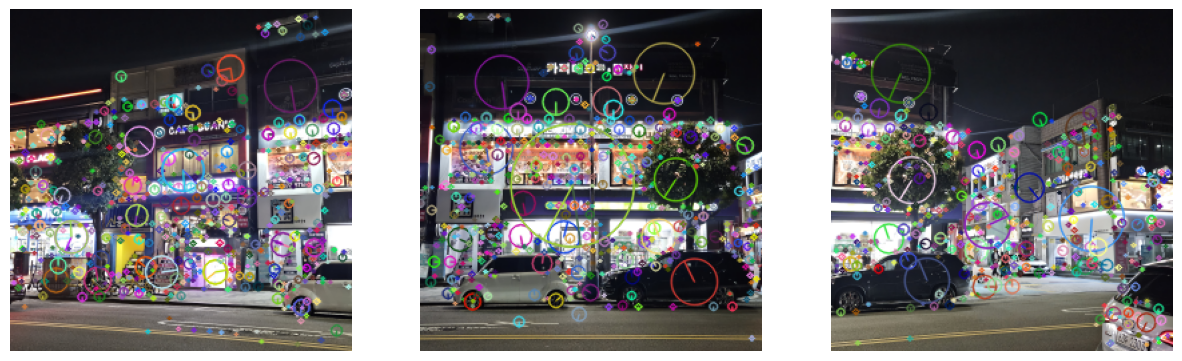

In [ ]:
fig = plt.figure()
rows, cols = 1, 3

ax1 = fig.add_subplot(rows, cols, 1)
ax1.imshow(cv2.drawKeypoints(cv2.cvtColor(img1, cv2.COLOR_RGB2BGR), 
                             keypoints1, 
                             outImage=None,
                             flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))
ax1.axis('off')

ax2 = fig.add_subplot(rows, cols, 2)
ax2.imshow(cv2.drawKeypoints(cv2.cvtColor(img2, cv2.COLOR_RGB2BGR), 
                             keypoints2, 
                             outImage=None,
                             flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))
ax2.axis('off')

ax3 = fig.add_subplot(rows, cols, 3)
ax3.imshow(cv2.drawKeypoints(cv2.cvtColor(img3, cv2.COLOR_RGB2BGR), 
                             keypoints3, 
                             outImage=None,
                             flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))
ax3.axis('off')

fig.set_figheight(15)
fig.set_figwidth(15)

plt.show()


93 96


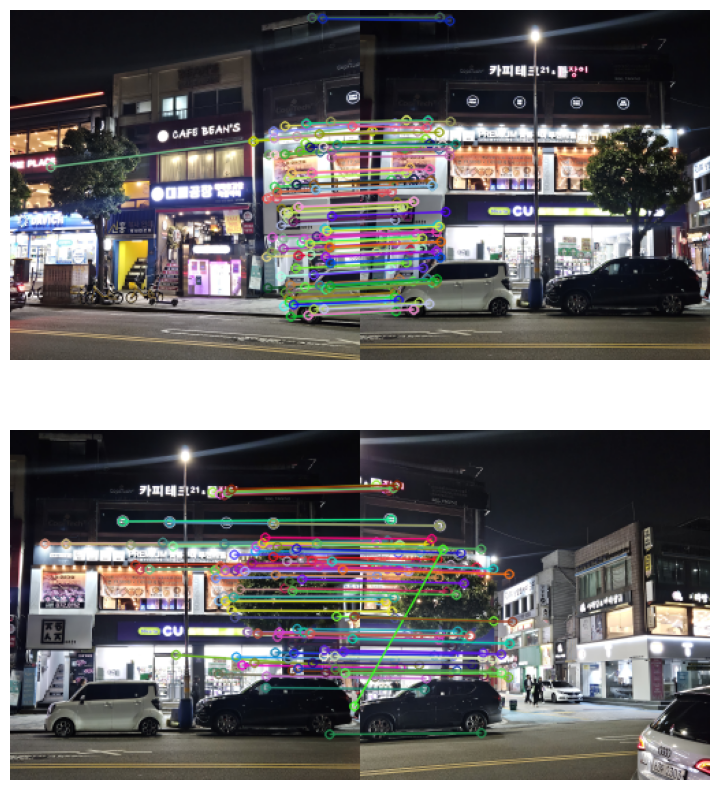

In [ ]:
bf = cv2.BFMatcher()
matches12 = bf.knnMatch(descriptors1, descriptors2, k=2)
matches23 = bf.knnMatch(descriptors2, descriptors3, k=2)

goodMatches12 = [i for i, j in matches12 if i.distance < j.distance * 0.7]
goodMatches23 = [i for i, j in matches23 if i.distance < j.distance * 0.7]

fig = plt.figure()
rows, cols = 2, 1

ax1 = fig.add_subplot(rows, cols, 1)
ax1.imshow(cv2.drawMatches(cv2.cvtColor(img1, cv2.COLOR_RGB2BGR), keypoints1, 
                           cv2.cvtColor(img2, cv2.COLOR_RGB2BGR), keypoints2, goodMatches12, None, flags=2))
ax1.axis('off')

ax2 = fig.add_subplot(rows, cols, 2)
ax2.imshow(cv2.drawMatches(cv2.cvtColor(img2, cv2.COLOR_RGB2BGR), keypoints2, 
                           cv2.cvtColor(img3, cv2.COLOR_RGB2BGR), keypoints3, goodMatches23, None, flags=2))
ax2.axis('off')

print(len(goodMatches12), len(goodMatches23))

fig.set_figheight(10)
fig.set_figwidth(10)

plt.show()

In [ ]:
# Step 2: Robust estimation of homography using RANSAC.


import sys
import random

def ransac(matches, kpt1, kpt2, iters):
    
    maxargsH = np.zeros((3, 3))
    maxMatches = []
    
    for _ in range(iters):
        rs = random.sample(range(len(matches)), 4)
        A, b = generateAb([matches[i] for i in rs], kpt1, kpt2)
        
        
        # nonsingular test
        if np.linalg.cond(A.T@A) < 1/sys.float_info.epsilon:
            
            H = homography(A, b)
            inlierMatches = inlierMatch(H, matches, kpt1, kpt2, 5)

            if len(maxMatches) < len(inlierMatches):
                maxargsH = H
                maxMatches = inlierMatches
    
    return maxargsH, maxMatches



def generateAb(matches, kpt1, kpt2):
    n = len(matches)
    A = np.zeros((n * 2, 8))
    b = np.zeros((n * 2, 1))
    
    for i in range(n):
        x , y  = kpt1[matches[i].queryIdx].pt
        x_, y_ = kpt2[matches[i].trainIdx].pt

        A[i*2]   = np.array([x, y, 1, 0, 0, 0, -x*x_, -y*x_]).reshape(-1)
        A[i*2+1] = np.array([0, 0, 0, x, y, 1, -x*y_, -y*y_]).reshape(-1)
        b[i*2:i*2+2] = np.array([x_, y_]).reshape(-1, 1)
    
    return A, b



def inlierMatch(H, matches, kpt1, kpt2, radius=3):
    
    validMatches=[]
    for m in matches:
        dist = np.linalg.norm(H@np.append(kpt1[m.queryIdx].pt, 1)\
                                  - np.append(kpt2[m.trainIdx].pt, 1))
        if dist < radius:
            validMatches.append(m)
     
    return validMatches



def homography(A, b):

    H = np.linalg.inv(A.T@A)@A.T@b
    H = np.append(H, np.array([1])).reshape(3, -1)
    return H

In [ ]:
H12, ransacMatches12 = ransac(goodMatches12, keypoints1, keypoints2, 10000)
len(ransacMatches12)

91

In [ ]:
H23, ransacMatches23 = ransac(goodMatches23, keypoints2, keypoints3, 10000)
len(ransacMatches23)

79

91 79


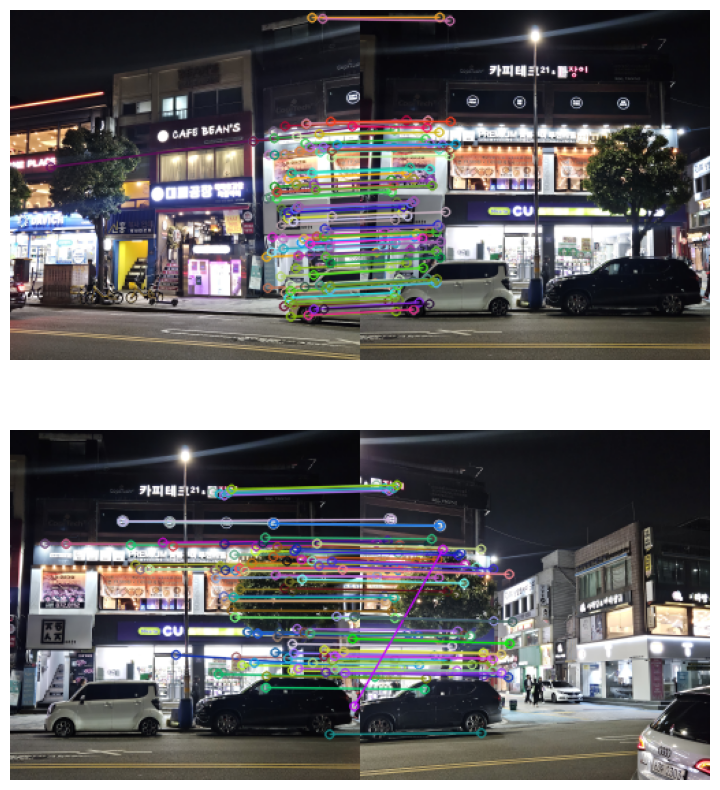

In [ ]:
fig = plt.figure()
rows, cols = 2, 1

ax1 = fig.add_subplot(rows, cols, 1)
ax1.imshow(cv2.drawMatches(cv2.cvtColor(img1, cv2.COLOR_RGB2BGR), keypoints1, 
                           cv2.cvtColor(img2, cv2.COLOR_RGB2BGR), keypoints2, goodMatches12, None, flags=2))
ax1.axis('off')

ax2 = fig.add_subplot(rows, cols, 2)
ax2.imshow(cv2.drawMatches(cv2.cvtColor(img2, cv2.COLOR_RGB2BGR), keypoints2, 
                           cv2.cvtColor(img3, cv2.COLOR_RGB2BGR), keypoints3, goodMatches23, None, flags=2))
ax2.axis('off')

print(len(ransacMatches12), len(ransacMatches23))

fig.set_figheight(10)
fig.set_figwidth(10)

plt.show()

In [ ]:
A12, b12 = generateAb(ransacMatches12, keypoints1, keypoints2)
A23, b23 = generateAb(ransacMatches23, keypoints2, keypoints3)

H12 = homography(A12, b12)
H23 = homography(A23, b23)

H12, H23

(array([[ 1.30481758e+00, -1.07409311e-01, -2.10255456e+02],
        [ 2.51114337e-01,  1.24786187e+00, -5.48038182e+01],
        [ 1.34065700e-03, -9.03262124e-05,  1.00000000e+00]]),
 array([[ 1.28556186e+00, -4.81754279e-02, -1.73951262e+02],
        [ 1.87327947e-01,  1.24386731e+00, -3.68149654e+01],
        [ 1.03783652e-03,  1.68225900e-04,  1.00000000e+00]]))

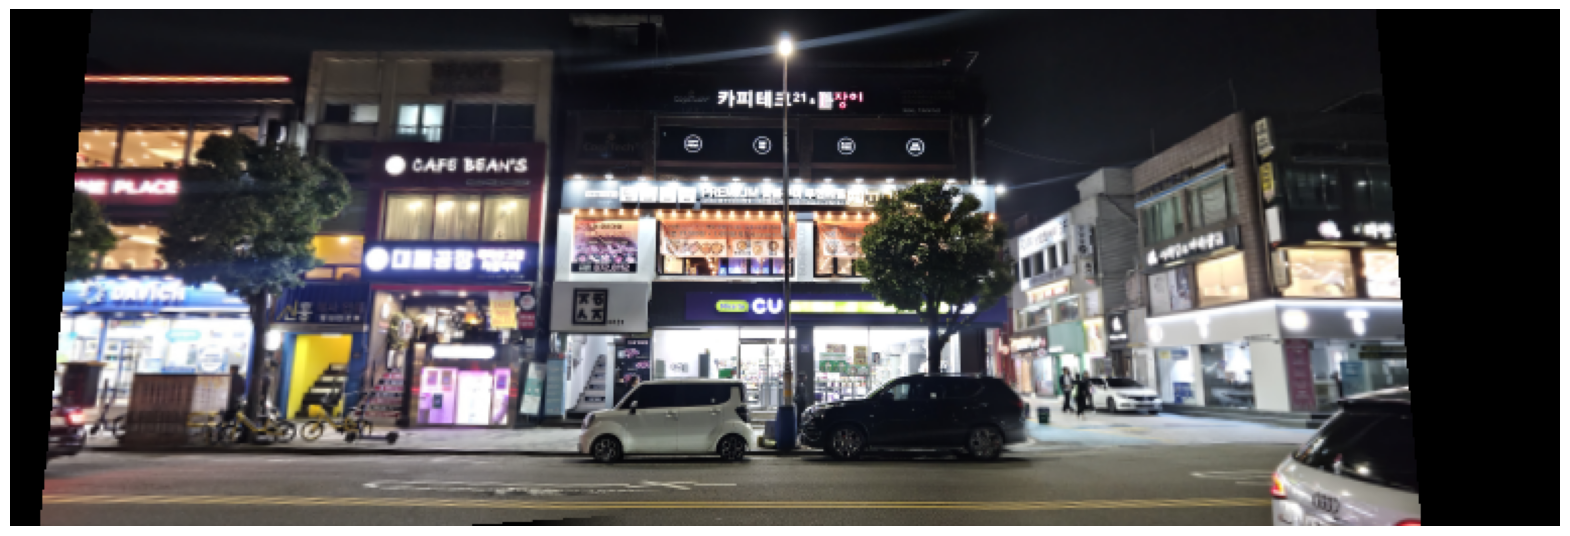

(<matplotlib.image.AxesImage at 0x155ef16dd60>, None)

In [ ]:
# Step 3: (Inverse) Image warping using homography matrix.
# Step 4: Blending overlapping pixels. Use alpha-blending.

def warp(H, pt):
    warpPt = H@np.float32(pt)
    warpPt /= warpPt[2]
    return warpPt



def alphaBlender(size=256, leftBlendLen=50, rightBlendLen=50):
    
    alpha = [1 for _ in range(size)]
    for i in range(leftBlendLen):
        alpha[i] = i / leftBlendLen
    for i in range(rightBlendLen):
        alpha[-i] = i / rightBlendLen        
    return alpha



def warpPerspective(img, H, T=np.identity(n=3)):
    for y_ in range(img_size[0]):
        for x_ in range(img_size[1] * 3):
            
            t  = warp(T, [x_, y_, 1])
            pt = warp(H, t)
            mx, Mx = int(np.floor(pt[0])), int(np.ceil(pt[0]))
            my, My = int(np.floor(pt[1])), int(np.ceil(pt[1]))
            
            a = pt[0] - mx
            b = pt[1] - my
            
            if 0 <= mx < 255 and 0 <= my < 255:
                warp_img[y_, x_] = \
                    (1-a)*(1-b)*img[my, mx] + a*(1-b)*img[my, Mx] \
                        + a*b*img[My, Mx] + (1-a)*b*img[My, mx]

                    
                    
warp_img = np.zeros((img_size[0], img_size[1] * 3, 3))

invH12 = np.linalg.inv(H12)
invH23 = np.linalg.inv(H23)

T = np.array(np.array([[1, 0, 256], [0, 1, 0], [0, 0, 1]]))
invT = np.linalg.inv(T)

warpPerspective(img1, invH12, invT)
warpPerspective(img3, H23, invT)


alphas = alphaBlender()
for y in range(img_size[0]):
    for x in range(img_size[1]):
            warp_img[y, img_size[1] + x] =\
                (1-alphas[x]) * warp_img[y, img_size[1] + x] \
                + alphas[x] * img2[y, x]
           

    
fig = plt.figure()
fig.set_size_inches(20, 20)
plt.axis('off')
plt.imshow(cv2.cvtColor(warp_img.astype('uint8'), cv2.COLOR_BGR2RGB)), plt.show()

### Vertical

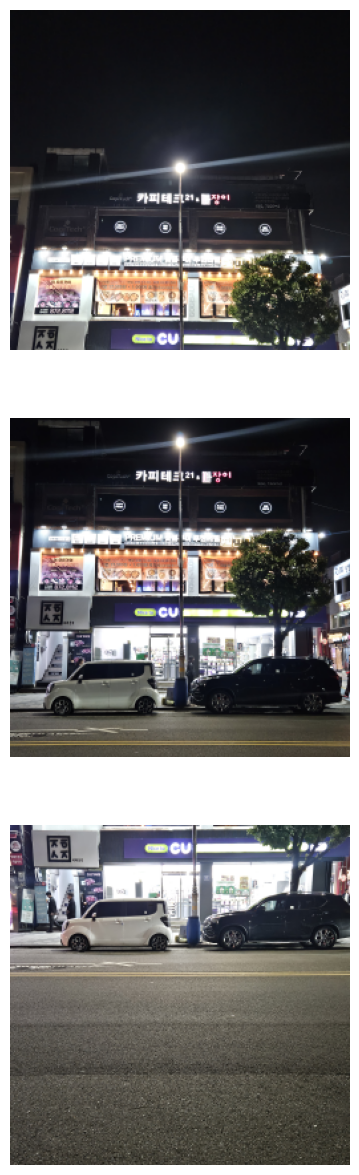

In [ ]:
fig = plt.figure()
rows, cols = 3, 1

ax1 = fig.add_subplot(rows, cols, 1)
ax1.imshow(cv2.cvtColor(img4, cv2.COLOR_RGB2BGR))
ax1.axis('off')

ax2 = fig.add_subplot(rows, cols, 2)
ax2.imshow(cv2.cvtColor(img2, cv2.COLOR_RGB2BGR))
ax2.axis('off')

ax3 = fig.add_subplot(rows, cols, 3)
ax3.imshow(cv2.cvtColor(img5, cv2.COLOR_RGB2BGR))
ax3.axis('off')

fig.set_figheight(15)
fig.set_figwidth(15)

plt.show()

In [ ]:
# Step 1: Feature extraction (SIFT) and matching between images to find correspondence candidates.

sift = cv2.SIFT_create()

keypoints4, descriptors4 = sift.detectAndCompute(img4, None)
keypoints2, descriptors2 = sift.detectAndCompute(img2, None)
keypoints5, descriptors5 = sift.detectAndCompute(img5, None)

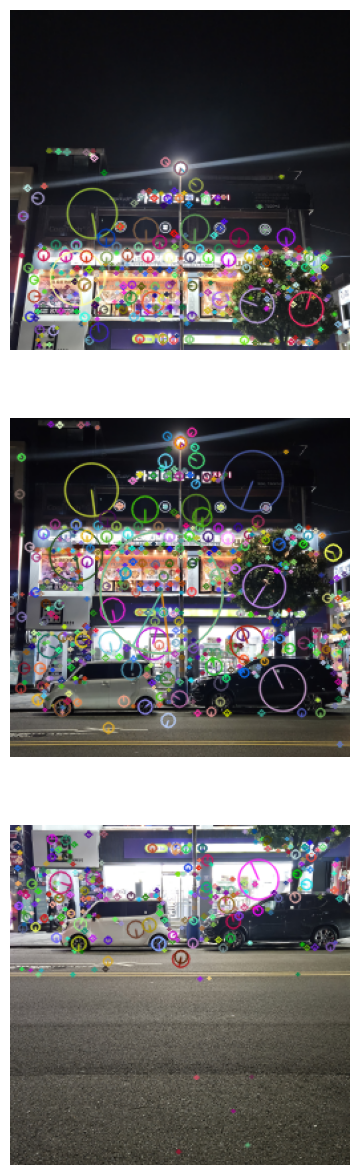

In [ ]:
fig = plt.figure()
rows, cols = 3, 1

ax1 = fig.add_subplot(rows, cols, 1)
ax1.imshow(cv2.drawKeypoints(cv2.cvtColor(img4, cv2.COLOR_RGB2BGR), 
                             keypoints4, 
                             outImage=None,
                             flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))
ax1.axis('off')

ax2 = fig.add_subplot(rows, cols, 2)
ax2.imshow(cv2.drawKeypoints(cv2.cvtColor(img2, cv2.COLOR_RGB2BGR), 
                             keypoints2, 
                             outImage=None,
                             flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))
ax2.axis('off')

ax3 = fig.add_subplot(rows, cols, 3)
ax3.imshow(cv2.drawKeypoints(cv2.cvtColor(img5, cv2.COLOR_RGB2BGR), 
                             keypoints5, 
                             outImage=None,
                             flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))
ax3.axis('off')

fig.set_figheight(15)
fig.set_figwidth(15)

plt.show()


198 99


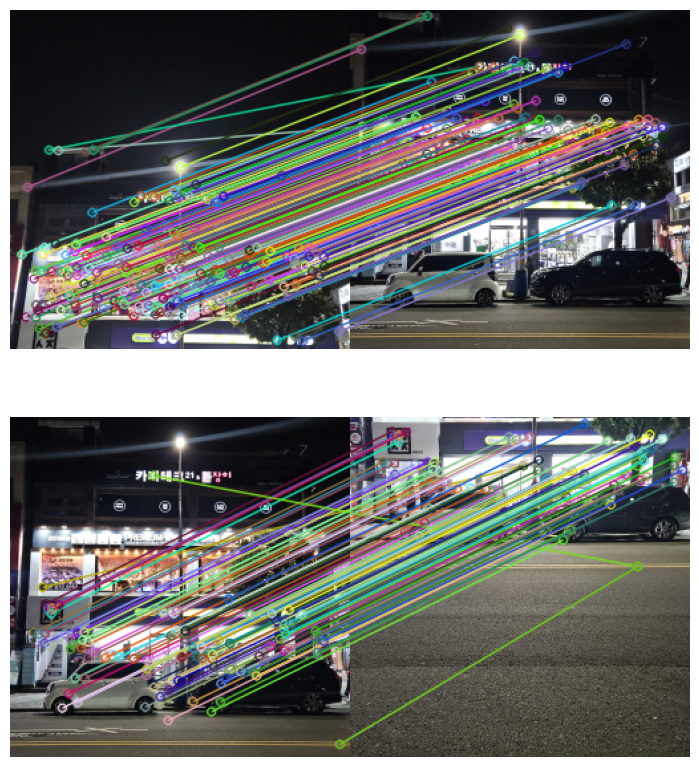

In [ ]:
bf = cv2.BFMatcher()
matches42 = bf.knnMatch(descriptors4, descriptors2, k=2)
matches25 = bf.knnMatch(descriptors2, descriptors5, k=2)

goodMatches42 = [i for i, j in matches42 if i.distance < j.distance * 0.7]
goodMatches25 = [i for i, j in matches25 if i.distance < j.distance * 0.7]

fig = plt.figure()
rows, cols = 3, 1

ax1 = fig.add_subplot(rows, cols, 1)
ax1.imshow(cv2.drawMatches(cv2.cvtColor(img4, cv2.COLOR_RGB2BGR), keypoints4, 
                           cv2.cvtColor(img2, cv2.COLOR_RGB2BGR), keypoints2, goodMatches42, None, flags=2))
ax1.axis('off')

ax2 = fig.add_subplot(rows, cols, 2)
ax2.imshow(cv2.drawMatches(cv2.cvtColor(img2, cv2.COLOR_RGB2BGR), keypoints2, 
                           cv2.cvtColor(img5, cv2.COLOR_RGB2BGR), keypoints5, goodMatches25, None, flags=2))
ax2.axis('off')

print(len(goodMatches42), len(goodMatches25))

fig.set_figheight(15)
fig.set_figwidth(10)

plt.show()


In [ ]:
# Step 2: Robust estimation of homography using RANSAC.


import sys
import random

def ransac(matches, kpt4, kpt2, iters):
    
    maxargsH = np.zeros((3, 3))
    maxMatches = []
    
    for _ in range(iters):
        rs = random.sample(range(len(matches)), 4)
        A, b = generateAb([matches[i] for i in rs], kpt4, kpt2)
        
        
        # nonsingular test
        if np.linalg.cond(A.T@A) < 1/sys.float_info.epsilon:
            
            H = homography(A, b)
            inlierMatches = inlierMatch(H, matches, kpt4, kpt2, 5)

            if len(maxMatches) < len(inlierMatches):
                maxargsH = H
                maxMatches = inlierMatches
    
    return maxargsH, maxMatches



def generateAb(matches, kpt4, kpt2):
    n = len(matches)
    A = np.zeros((n * 2, 8))
    b = np.zeros((n * 2, 1))
    
    for i in range(n):
        x , y  = kpt4[matches[i].queryIdx].pt
        x_, y_ = kpt2[matches[i].trainIdx].pt

        A[i*2]   = np.array([x, y, 1, 0, 0, 0, -x*x_, -y*x_]).reshape(-1)
        A[i*2+1] = np.array([0, 0, 0, x, y, 1, -x*y_, -y*y_]).reshape(-1)
        b[i*2:i*2+2] = np.array([x_, y_]).reshape(-1, 1)
    
    return A, b



def inlierMatch(H, matches, kpt4, kpt2, radius=3):
    
    validMatches=[]
    for m in matches:
        dist = np.linalg.norm(H@np.append(kpt4[m.queryIdx].pt, 1)\
                                  - np.append(kpt2[m.trainIdx].pt, 1))
        if dist < radius:
            validMatches.append(m)
     
    return validMatches



def homography(A, b):

    H = np.linalg.inv(A.T@A)@A.T@b
    H = np.append(H, np.array([1])).reshape(3, -1)
    return H

In [ ]:
H42, ransacMatches42 = ransac(goodMatches42, keypoints4, keypoints2, 10000)
len(ransacMatches42)

189

In [ ]:
H25, ransacMatches25 = ransac(goodMatches25, keypoints2, keypoints5, 10000)
len(ransacMatches25)

95

189 95


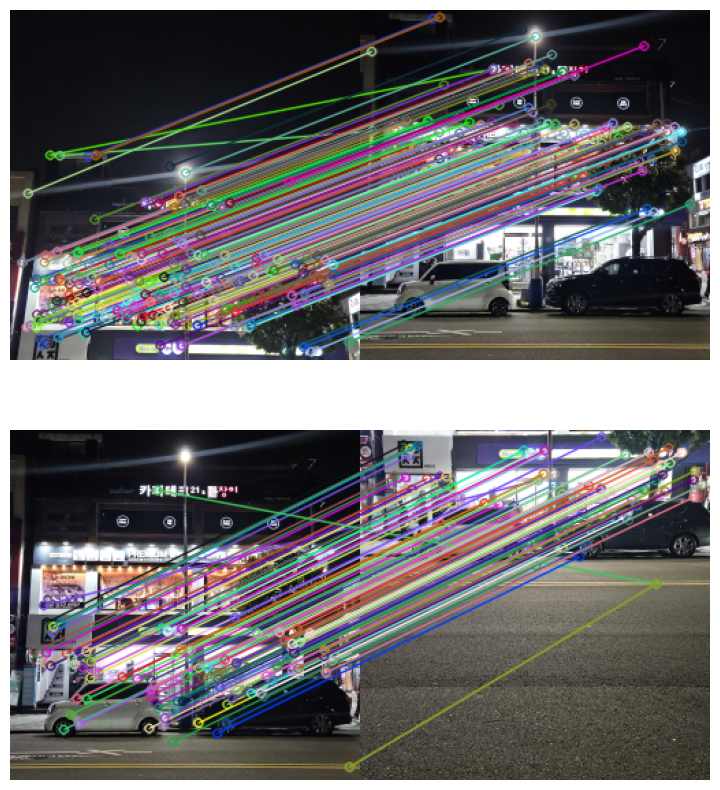

In [ ]:
fig = plt.figure()
rows, cols = 2, 1

ax1 = fig.add_subplot(rows, cols, 1)
ax1.imshow(cv2.drawMatches(cv2.cvtColor(img4, cv2.COLOR_RGB2BGR), keypoints4, 
                           cv2.cvtColor(img2, cv2.COLOR_RGB2BGR), keypoints2, goodMatches42, None, flags=2))
ax1.axis('off')

ax2 = fig.add_subplot(rows, cols, 2)
ax2.imshow(cv2.drawMatches(cv2.cvtColor(img2, cv2.COLOR_RGB2BGR), keypoints2, 
                           cv2.cvtColor(img5, cv2.COLOR_RGB2BGR), keypoints5, goodMatches25, None, flags=2))
ax2.axis('off')

print(len(ransacMatches42), len(ransacMatches25))

fig.set_figheight(10)
fig.set_figwidth(10)

plt.show()

In [ ]:
A42, b42 = generateAb(ransacMatches42, keypoints4, keypoints2)
A25, b25 = generateAb(ransacMatches25, keypoints2, keypoints5)

H42 = homography(A42, b42)
H25 = homography(A25, b25)

H42, H25

(array([[ 1.17583494e+00,  1.17545890e-01, -2.14156456e+01],
        [-1.32869251e-03,  1.24055003e+00, -1.25166487e+02],
        [ 2.77531889e-05,  9.46549883e-04,  1.00000000e+00]]),
 array([[ 1.22652593e+00,  1.86321523e-01, -2.16725513e+01],
        [-1.67512374e-02,  1.32966171e+00, -1.73495280e+02],
        [-1.68177995e-04,  1.38542681e-03,  1.00000000e+00]]))

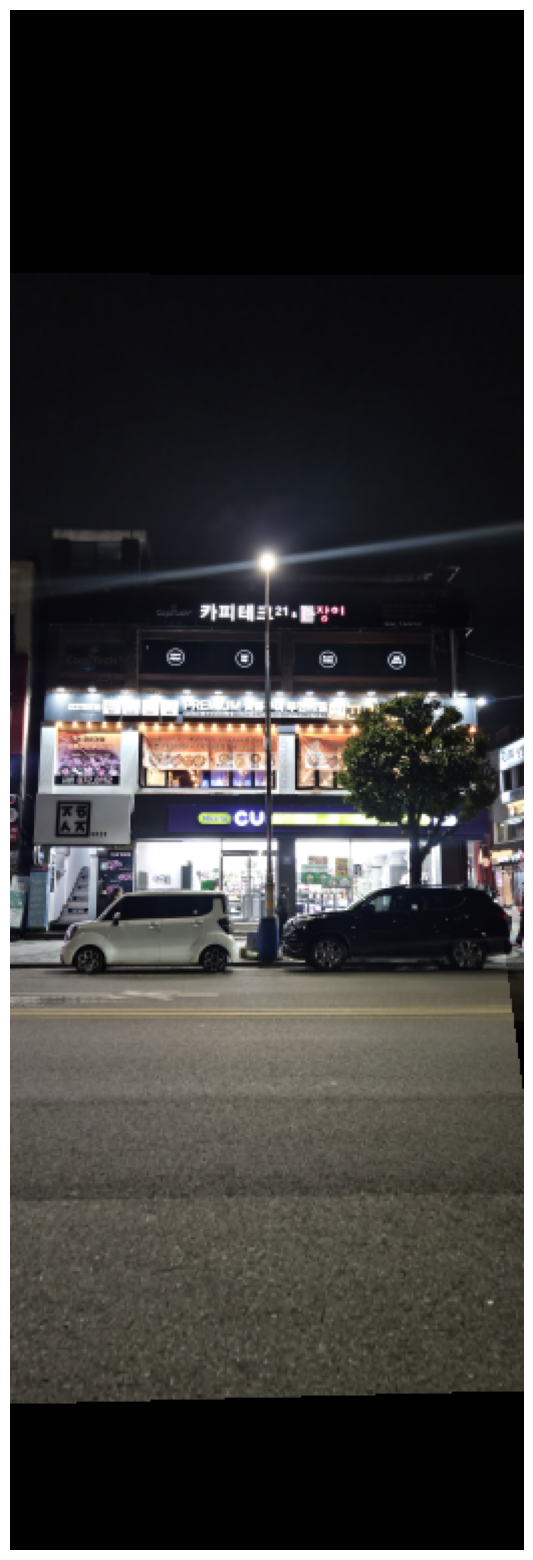

In [ ]:
# Step 3: (Inverse) Image warping using homography matrix.
# Step 4: Blending overlapping pixels. Use alpha-blending.
#

def warp(H, pt):
    warpPt = H @ np.float32(pt)
    warpPt /= warpPt[2]
    return warpPt

def alphaBlender(size=256, topBlendLen=50, bottomBlendLen=50):
    alpha = [1 for _ in range(size)]
    for i in range(topBlendLen):
        alpha[i] = i / topBlendLen
    for i in range(bottomBlendLen):
        alpha[-i] = i / bottomBlendLen        
    return alpha

def warpPerspective(img, H, T=np.identity(3)):
    for y_ in range(img_size[0] * 3):
        for x_ in range(img_size[1]):
            t = warp(T, [x_, y_, 1])
            pt = warp(H, t)
            mx, Mx = int(np.floor(pt[0])), int(np.ceil(pt[0]))
            my, My = int(np.floor(pt[1])), int(np.ceil(pt[1]))
            
            a = pt[0] - mx
            b = pt[1] - my
            
            if 0 <= mx < 255 and 0 <= my < 255:
                warp_img[y_, x_] = (
                    (1-a)*(1-b)*img[my, mx] + a*(1-b)*img[my, Mx] +
                    a*b*img[My, Mx] + (1-a)*b*img[My, mx]
                )

warp_img = np.zeros((img_size[0] * 3, img_size[1], 3))

invH12 = np.linalg.inv(H42)
invH23 = np.linalg.inv(H25)

T = np.array([[1, 0, 0], [0, 1, 256], [0, 0, 1]])
invT = np.linalg.inv(T)

warpPerspective(img4, invH12, invT)
warpPerspective(img5, H25, invT)

alphas = alphaBlender()
for y in range(img_size[0]):
    for x in range(img_size[1]):
        warp_img[y + img_size[0], x] = (
            (1-alphas[y]) * warp_img[y + img_size[0], x] +
            alphas[y] * img2[y, x]
        )

fig = plt.figure()
fig.set_size_inches(20, 20)
plt.axis('off')
plt.imshow(cv2.cvtColor(warp_img.astype('uint8'), cv2.COLOR_BGR2RGB))
plt.show()
